In [1]:
import torch

import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image


from __future__ import print_function, division

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
import torchvision.datasets as dset
import torchvision.transforms as T

from torch.utils.data import DataLoader 
from torch.utils.data import sampler
from torch.utils.data import Dataset

import time
import os
import copy
import glob
import os.path as osp
from PIL import Image
import pickle


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as dset

from torch.utils.data import DataLoader, sampler, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

class MOVIES(Dataset):

    def __init__(self, images_folder, labels_doc, transform=None, preload=False, train=True):
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = images_folder
        self.transform = transform
        self.train = train
            
        all_filenames = pd.read_csv(images_folder + '/' + labels_doc)        
        
        filenames = all_filenames['filename']
        
        # labels are read in this order:
        # 'Action', 'Thriller', 'Adventure', 'Animation', 'Western', 'Comedy', 
        # 'Crime', 'Drama', 'Horror', 'Romance', 'Science Fiction', 'Fantasy', 
        # 'Family', 'Documentary', 'History', 'Music', 'Mystery', 'TV Movie', 'War'
        labels = all_filenames[all_filenames.columns[2:]]
        
        for idx, fn in enumerate(filenames):
            self.filenames.append((fn, list(labels.iloc[idx]))) # (filename, labels)

        self.len = len(self.filenames)

    def __getitem__(self, index):
        
        image_fn, label = self.filenames[index]
        label = label[7] # Get drama label
        image = Image.open('Data/posters_images/'+image_fn)

        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
            
        # return image and label
        return image, label
    
    def __len__(self):
        # Total number of samples in the dataset
        return self.len
    
def load_data(batchsize=1):
    image_folder = 'Data/poster_label_files'
    Train_images_labels = 'Dataset_Training_3345.csv'
    Val_images_labels = 'Dataset_Validation_955.csv'
    Test_images_labels = 'Dataset_Test_479.csv'

    BATCHSIZE = batchsize #cifar10 set to 64
    
    data_transforms = T.Compose([
                T.Resize((224,224)),
                T.ToTensor()])    

    poster_train = MOVIES(image_folder, Train_images_labels, transform=data_transforms, train=True)
    poster_val = MOVIES(image_folder, Val_images_labels, transform=data_transforms, train=True)
    poster_test = MOVIES(image_folder, Test_images_labels, transform=data_transforms, train=True)

    dataloaders = {}
    dataloaders['train'] = DataLoader(poster_train, batch_size=BATCHSIZE)
    dataloaders['val'] = DataLoader(poster_val, batch_size=BATCHSIZE)
    dataloaders['test'] = DataLoader(poster_test, batch_size=BATCHSIZE)
    
    return dataloaders, poster_train, poster_val, poster_test
   


In [3]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [4]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.resnet18(pretrained=True)

# for param in model_conv.parameters():
#     param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

In [5]:
batchsize=10
dataloaders, poster_train, poster_val, poster_test = load_data(batchsize=batchsize)
dataset_sizes = {}
dataset_sizes['train'] = len(dataloaders['train'])
dataset_sizes['val'] = len(dataloaders['val'])


In [6]:
X = []
y = []
i =0
for images, labels in dataloaders['train']:
    i =i +1
    if i>5:
        break
    npimg = images[0].data.cpu().numpy()
    npimg =np.transpose(npimg, (1, 2, 0))
    X.append(npimg)
    y.append(labels[0])
X = np.array(X)
y = np.array(y)
print(len(X))
print(len(y))

5
5


In [7]:
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[-1.1044, -0.9242, -2.5590, -0.1704,  1.8523],
        [ 1.3506,  0.0404, -0.4282,  1.6081, -0.3751],
        [ 0.5430,  0.9586, -0.2879, -0.4839, -0.0056],
        [ 1.2559, -0.3173,  0.3527, -1.1517,  0.2787]])
tensor([ 1,  2,  1,  3])
tensor([-0.9242, -0.4282,  0.9586, -1.1517])


In [8]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    loss = model(X).gather(1, y.view(-1, 1)).squeeze().sum()
    loss.backward()
    with torch.no_grad():
        saliency = torch.max(X.grad.abs(), dim =1)[0]
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

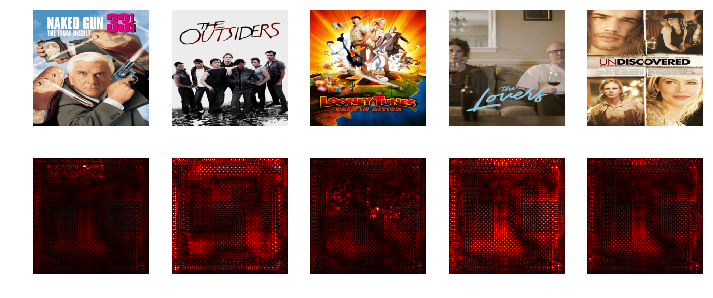

In [9]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors


    X_tensor = torch.cat([preprocess(Image.fromarray(x.astype('uint8'))) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()


show_saliency_maps(X, y)